## Training an Autoencoder With TensorNodes

When working with TensorNodes you can train them just like normal parts of a Nengo model. The only deviation from the standard procedure is the definition of the custom classes which encapsulate the Tensorflow portions. 

In this example we will illustrate this trainability by training an autoencoder on the MNIST dataset. The autoencoder takes the input in with a dimensionality of `784` (28\*28) and reduces it to a dimensionality of `128`. This is the encoding phase where the network is effectively compressing the input. The decode phase then takes that `128` dimension representation and attempts to reconstruct the original input with it.

We shown at the bottom of the notebook how the training changes the output. The output starts off as pure noise and gradually looks more and more like the input. Culminating with easily identifiable reconstructions. The training of this network took ~30 minutes on a _Quadro M4000 GPU_, so although not infeasible to go through the training yourself a pretrained model is available for your convenience. To enable the loading of the pretrained model simply set the `LOADING` flag to `True`

In [1]:
%matplotlib inline

import nengo
import nengo_dl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
from urllib.request import urlretrieve
import zipfile

LOADING = False

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The network architecture consists of one input layer followed by 4 densly connected layers. The layers architecture is mirrored such that:

```
Layer 1: 784 Elements - Input

Layer 2: 256 Elements - Encode 1

Layer 3: 128 Elements - Encode 2

Layer 4: 256 Elements - Decode 1

Layer 5: 784 Elements - Decode 2/Output
```

In [3]:
# Network Parameters
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)

The TensorNodes are broken up into two classes, an Encoder, which compresses the input; and a Decoder, which decompresses the output to attempt to recreate the original.

Both of the TensorNode types consist of two fully connected (dense) layers which are in turn connected to each other

In [4]:
# Building the encoder
class Encoder(object):
    def pre_build(self, shape_in, shape_out):
        self.n_mini = shape_in[0]
        self.size_in = shape_in[1]
        self.size_out = shape_out[1]
        
    
    def __call__(self, t, x):    
        dense = tf.contrib.layers.fully_connected(x, n_hidden_1)
        dense = tf.contrib.layers.fully_connected(dense, n_hidden_2)

        return dense


# Building the encoder
class Decoder(object):
    def pre_build(self, shape_in, shape_out):
        self.n_mini = shape_in[0]
        self.size_in = shape_in[1]
        self.size_out = shape_out[1]
    
    def __call__(self, t, x):    
        dense = tf.contrib.layers.fully_connected(x, n_hidden_1)
        dense = tf.contrib.layers.fully_connected(dense, self.size_out)

        return dense


with nengo.Network() as net:
     # create node to feed in images
    inp = nengo.Node(nengo.processes.PresentInput(mnist.test.images, 0.001*10))
    
    # create TensorNodes to insert into the network
    tf_encode = nengo_dl.TensorNode(Encoder(), size_in=28 * 28, size_out=n_hidden_2, label='H1')
    tf_decode = nengo_dl.TensorNode(Decoder(), size_in=n_hidden_2, size_out=n_input, label='H2')
    
    # connecting all the nodes together
    nengo.Connection(inp, tf_encode)
    nengo.Connection(tf_encode, tf_decode)
    
    # defining probes
    input_probe = nengo.Probe(inp)
    output_probe = nengo.Probe(tf_decode)

Luckily for this network the training data for output and input are the same, therefore the same data can be used for both. We utilize Nengo's built in `PresentInput` method to pass in the MNIST images.

In [5]:
def gen_data(steps, batchsize, pos):
    # defining the training data
    test_in_data = []
    test_out_data = []
    outputs = []
    output_array = []
    input_array = []
    for k in range(batchsize):
        input_array.append(nengo.processes.PresentInput(mnist.train.images[pos + k:], 0.001*steps).run(0.001*steps))
    in_dict = {inp:np.asarray(input_array)}
    out_dict = {output_probe:np.asarray(input_array)}
    return in_dict, out_dict

To train the network you first break the dataset up into batches of 64 images, then feed those batches into the network. You repeat this process for a set amount of repetitions (runs through the dataset). The amount of repetitions can be modified at your discretion, but it was found that 15 gives results which are allowable (more repetitions would result in a more accurate output at the cost of an increased training time, to a point).

In [ ]:
n_examples = 64
n_iters = int(55000/(n_examples))
losses = []
start_time = time.time()
round_time = 0
learning_rate = 0.05
steps = 10
counted = 0
delta = 1
repetitions = 15
with nengo_dl.Simulator(net, step_blocks=steps, minibatch_size=n_examples) as sim:
    if LOADING:
        # Running an example through the network so the difference of training is shown
        input_dict, output_dict = gen_data(steps, n_examples, 0)
        losses.append(sim.loss(input_dict, output_dict, 'mse'))
        sim.run(0.001*steps)
        param_path = os.path.join("nengo_autoencoder", "Nengo-Autoencoder")
        # Checking if parameters are already downloaded, if not retrieve them
        if not os.path.exists("nengo_autoencoder"):
            os.mkdir("nengo_autoencoder")
        if not os.path.exists(param_path + ".index"):
            param_zip_path = os.path.join("nengo_autoencoder", "nengo-autoencoder-params.zip")
            urlretrieve("https://github.com/clvcooke/nengo_dl/raw/master/docs/examples/Nengo-Autoencoder-Weights.zip", param_zip_path)
            with zipfile.ZipFile(param_zip_path) as f:
                f.extractall("nengo_autoencoder")
            os.remove(param_zip_path)
        sim.load_params(param_path)
    else:
        optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
        for e in range(repetitions):
            input_dict, output_dict = gen_data(steps, n_examples, 0)
            losses.append(sim.loss(input_dict, output_dict, 'mse'))
            print(losses)

            if counted>0:
                old_delta = delta
                delta = losses[counted] - losses[counted-1]
                print("delta: " +str(losses[counted] - losses[counted-1]) )
            sim.run(0.001*steps)
            counted = counted + 1
            for i in range(n_iters):
                print(str(i+1) + "/" + str(n_iters))
                input_dict, output_dict = gen_data(steps, n_examples, n_examples*i)
                sim.train(input_dict,
                         output_dict,
                         optimizer,
                         n_epochs=2)
                round_time = (round_time*(i) + time.time() - start_time) / (i+1)
                start_time = time.time()
                print("ETA: ~" + str(round_time*((10-e)*n_iters - i-1)/60) + " minutes")
    losses.append(sim.loss(input_dict, output_dict, 'mse'))
    print(losses)
    if counted>0:
        print("delta: " +str(losses[counted] - losses[counted-1]) )
    sim.run(0.001*steps)
    counted = counted + 1

The plot below shows the input on the top row, then the reconstructed output on the bottom. We can see that as training progresses (moving left to right) the reconstructions become more and more accurate. 

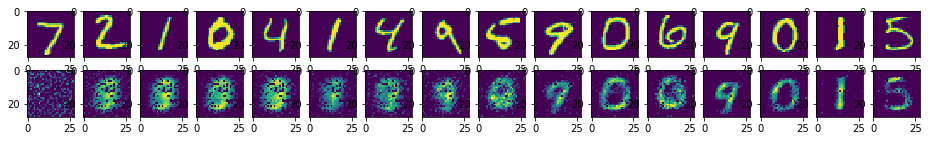

In [10]:
figure, axis = plt.subplots(2, len(losses), figsize=(len(losses),2))
for i in range(0, len(losses)):
    axis[0][i].imshow(np.reshape(sim.data[input_probe][0][i*steps+steps-1], (28, 28)))
    axis[1][i].imshow(np.reshape(sim.data[output_probe][0][i*steps+steps-1], (28, 28)))